<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 24: Autoencoders
### Notebook 3: Exploring latent variables

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is still in the hacked-together form used to develop the figures, and is only lightly commented.

In [1]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Input, MaxPooling2D, UpSampling2D
from keras.utils import np_utils
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pathlib import Path

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [3]:
random_seed = 42
np.random.seed(random_seed)

# load the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# cast the sample data to the current Keras floating-point type
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# reshape to 2D grid, one line per image
X_train = X_train.reshape(X_train.shape[0], number_of_pixels)
X_test = X_test.reshape(X_test.shape[0], number_of_pixels)

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# reshape sample data to 4D tensor using channels_last convention
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

In [4]:
CAE_encoder_input = Input(shape=(28,28, 1))
CAE_encoder_conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
CAE_encoder_pool_1 = MaxPooling2D((2,2), padding='same')
CAE_encoder_conv_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
CAE_encoder_pool_2 = MaxPooling2D((2,2), padding='same')
CAE_encoder_output = Conv2D(3, (3, 3), activation='relu', padding='same')

CAE_decoder_up_1 = UpSampling2D((2,2))
CAE_decoder_conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
CAE_decoder_up_2 = UpSampling2D((2,2))
CAE_decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

CAE_encoder_step_1 = CAE_encoder_conv_1(CAE_encoder_input)
CAE_encoder_step_2 = CAE_encoder_pool_1(CAE_encoder_step_1)
CAE_encoder_step_3 = CAE_encoder_conv_2(CAE_encoder_step_2)
CAE_encoder_step_4 = CAE_encoder_pool_2(CAE_encoder_step_3)
CAE_encoder_step_5 = CAE_encoder_output(CAE_encoder_step_4)

CAE_decoder_step_1 = CAE_decoder_up_1(CAE_encoder_step_5)
CAE_decoder_step_2 = CAE_decoder_conv_1(CAE_decoder_step_1)
CAE_decoder_step_3 = CAE_decoder_up_2(CAE_decoder_step_2)
CAE_decoder_step_4 = CAE_decoder_output(CAE_decoder_step_3)


Conv_AE = Model(CAE_encoder_input, CAE_decoder_step_4)
Conv_AE.compile(optimizer='adadelta', loss='binary_crossentropy')


Conv_AE_encoder_only_model = Model(CAE_encoder_input, CAE_encoder_step_5)
                    
Conv_AE_decoder_only_input = Input(shape=(7, 7, 3))
Conv_AE_decoder_only_step_1 = CAE_decoder_up_1(Conv_AE_decoder_only_input)
Conv_AE_decoder_only_step_2 = CAE_decoder_conv_1(Conv_AE_decoder_only_step_1)
Conv_AE_decoder_only_step_3 = CAE_decoder_up_2(Conv_AE_decoder_only_step_2)
Conv_AE_decoder_only_step_4 = CAE_decoder_output(Conv_AE_decoder_only_step_3)
                      
Conv_AE_decoder_only_model = Model(Conv_AE_decoder_only_input, Conv_AE_decoder_only_step_4)

In [6]:
weights_filename = "NB3-Conv-AE-weights"
np.random.seed(42)
if not file_helper.load_model_weights(Conv_AE, weights_filename):
    Conv_AE.fit(X_train, X_train,
               epochs=50, batch_size=128, shuffle=True,
               verbose=2,
               validation_data=(X_test, X_test))
    file_helper.save_model_weights(Conv_AE, weights_filename)

In [7]:
def draw_predictions_set(predictions, filename=None):
    plt.figure(figsize=(8, 4))
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i+6)
        plt.imshow(predictions[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    file_helper.save_figure(filename+'-predictions')
    plt.show()

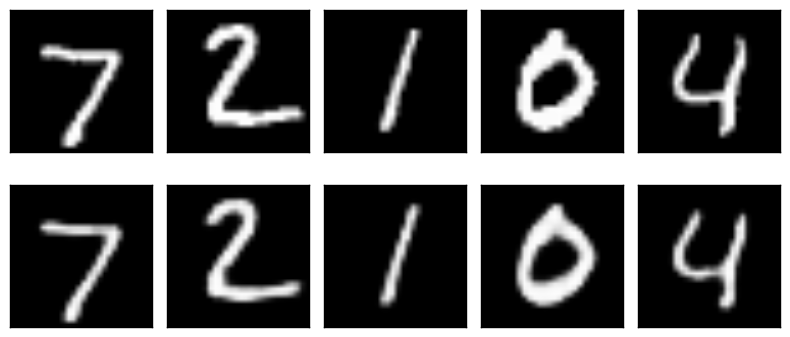

In [8]:
Conv_predictions = Conv_AE.predict(X_test)
draw_predictions_set(Conv_predictions, 'NB3-ConvAE-predictions')

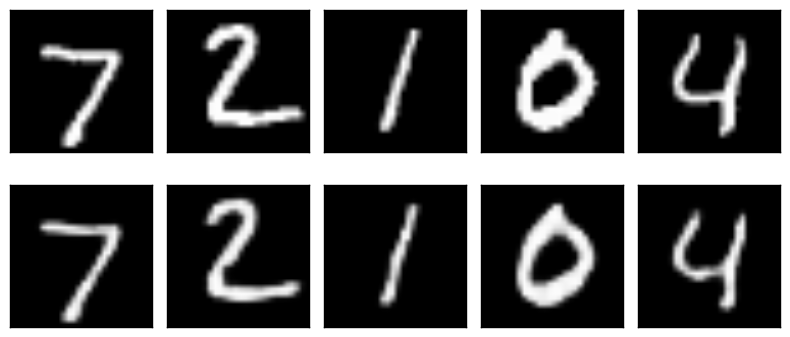

In [9]:
Conv_latents = Conv_AE_encoder_only_model.predict(X_test)
conv_noisy_in = Conv_latents.copy()[0:5]
noise = 1
for i in range(5):
    for v2 in range(7):
        for v3 in range(7):
            conv_noisy_in[i,v2,v3] += np.random.uniform(low=-noise, high=noise)
conv_noisy_predictions = Conv_AE_decoder_only_model.predict(conv_noisy_in)
conv_noisy_predictions.shape
draw_predictions_set(conv_noisy_predictions, 'NB3-ConvAE-noise-add-1')

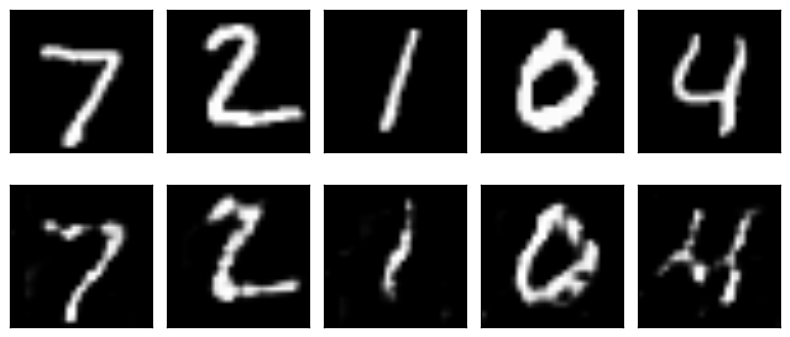

In [10]:
Conv_latents = Conv_AE_encoder_only_model.predict(X_test)
conv_noisy_in = Conv_latents.copy()[0:5]
noise = 5
for i in range(5):
    for v2 in range(7):
        for v3 in range(7):
            conv_noisy_in[i,v2,v3] += np.random.uniform(low=-noise, high=noise)
conv_noisy_predictions = Conv_AE_decoder_only_model.predict(conv_noisy_in)
conv_noisy_predictions.shape
draw_predictions_set(conv_noisy_predictions, 'NB3-ConvAE-noise-add-5')

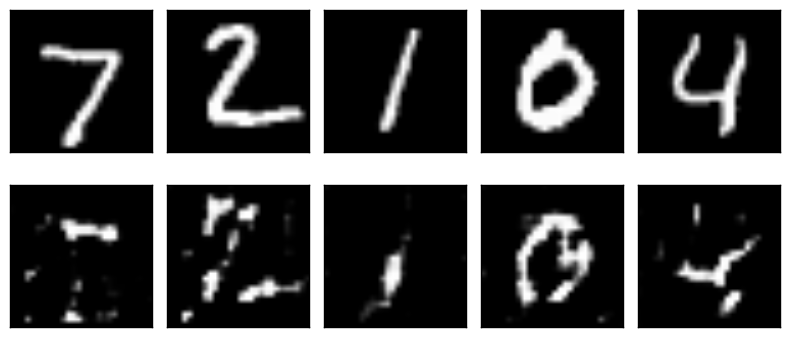

In [11]:
Conv_latents = Conv_AE_encoder_only_model.predict(X_test)
conv_noisy_in = Conv_latents.copy()[0:5]
noise = 10
for i in range(5):
    for v2 in range(7):
        for v3 in range(7):
            conv_noisy_in[i,v2,v3] += np.random.uniform(low=-noise, high=noise)
conv_noisy_predictions = Conv_AE_decoder_only_model.predict(conv_noisy_in)
conv_noisy_predictions.shape
draw_predictions_set(conv_noisy_predictions, 'NB3-ConvAE-noise-add-10')

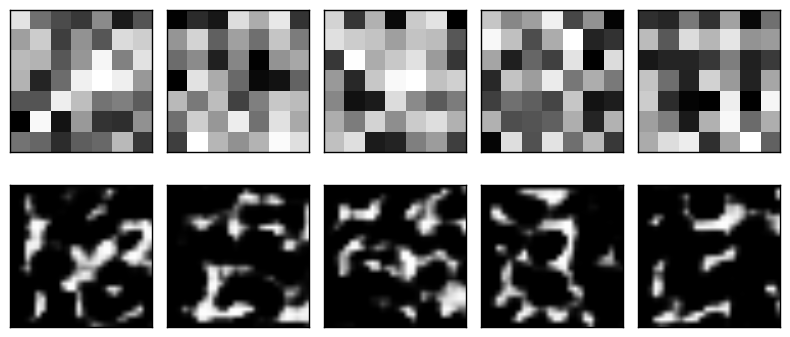

In [12]:
conv_noisy_in = np.random.uniform(low=0, high=16, size=(5*7*7*3))
conv_noisy_in = np.reshape(conv_noisy_in, (5,7,7,3))
conv_noisy_predictions = Conv_AE_decoder_only_model.predict(conv_noisy_in)

plt.clf()
plt.figure(figsize=(8, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(conv_noisy_in[i,:,:,0].reshape(7, 7), cmap="gray", interpolation='nearest')
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.subplot(2, 5, i+6)
    plt.imshow(conv_noisy_predictions[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure('NB3-ConvAE-all-noise-predictions')
plt.show()

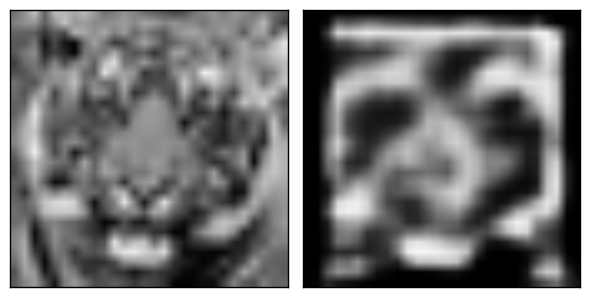

In [13]:
from PIL import Image
filepath = file_helper.get_input_file_path("tiger-gray-28-28.png")
im = Image.open(filepath) #Can be many different formats.
pix = im.load()
tiger = np.zeros((1,784))
for y in range(28):
    for x in range(28):
        tiger[0,(y*28)+x] = pix[x,y][0]/255.
tiger = np.reshape(tiger, (1, 28, 28, 1))
        
predicted_tiger = Conv_AE.predict(tiger)

plt.subplot(1, 2, 1)
plt.imshow(np.reshape(tiger, (28, 28)), vmin=0, vmax=1, cmap="gray")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.subplot(1, 2, 2)
plt.imshow(np.reshape(predicted_tiger, (28, 28)), vmin=0, vmax=1, cmap="gray")
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB3-ConvAE-tiger-pair")
plt.show()

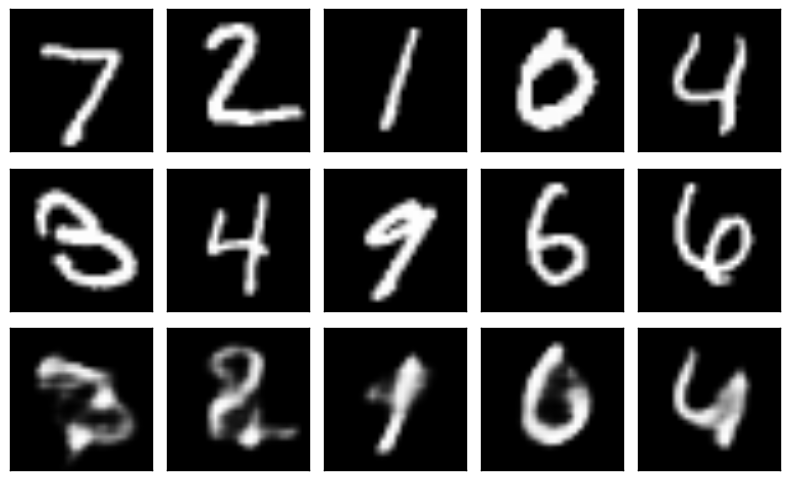

In [14]:
# blend latents for two test images and decompress
encoder_predictions = np.array(Conv_AE_encoder_only_model.predict(X_test))
np.random.seed(random_seed)

plt.figure(figsize=(8, 5))
offset = 18
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+6)
    plt.imshow(X_test[i+offset].reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.subplot(3, 5, i+11)
    latent0 = np.reshape(encoder_predictions[i], (3*7*7,))
    latent1 = np.reshape(encoder_predictions[i+offset], (3*7*7,))
    latent_mix = [(latent0[i]+latent1[i])/2. for i in range(len(latent0))]
    latent_mix = np.reshape(latent_mix, (1,7,7,3))
    decoder_prediction = Conv_AE_decoder_only_model.predict(latent_mix)
    plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB3-ConvAE-blend-grid")
plt.show()

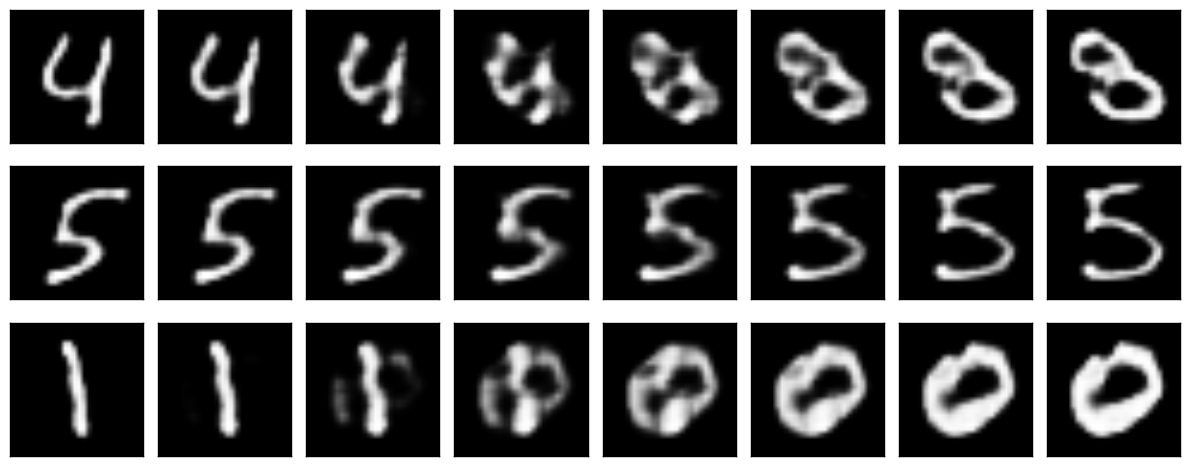

In [15]:
# blend latents for two test images and decompress
encoder_predictions = np.array(Conv_AE_encoder_only_model.predict(X_test))
np.random.seed(random_seed)

steps = 8
plt.figure(figsize=(12, 5))
latent0_list = [ encoder_predictions[4], encoder_predictions[23], encoder_predictions[29]]
latent1_list = [ encoder_predictions[18], encoder_predictions[15], encoder_predictions[25]]

for r in range(3):
    latent0 = np.reshape(latent0_list[r], (3*7*7,))
    latent1 = np.reshape(latent1_list[r], (3*7*7,))
    for i in range(steps): 
        plt.subplot(3, steps, (steps*r)+(i+1))
        alpha = i/(steps-1.0)
        latent_mix = [latent0[i]+(alpha*(latent1[i]-latent0[i])) for i in range(len(latent0))]
        latent_mix = np.reshape(latent_mix, (1, 7, 7, 3))
        decoder_prediction = Conv_AE_decoder_only_model.predict(latent_mix)
        plt.imshow(decoder_prediction.reshape(28, 28), cmap="gray")
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.tight_layout()
file_helper.save_figure("NB3-ConvAE-blend-linear")
plt.show()